# 🧠 __AI-Powered ECG Image Analysis Model__
This project classifies ECG images into medical categories using ANN, CNN, and VGG-19 models. It includes preprocessing, class balancing (SMOTE), training, evaluation, and model saving for deployment.
___
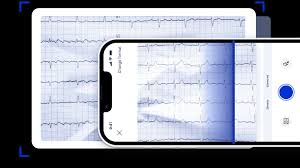 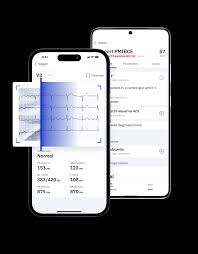


## __Step-1:__ Setup, Data Loading, and Visualization

In [2]:
# @title __1.1__ Import Required Libraries

# Basic Libraries
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Machine Learning Libraries
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
tf.keras.backend.clear_session()

In [3]:
# @title __1.2__ Extract Dataset

# Define Paths
zip_path = '/input_path/ECG Images Dataset/ECG Images Dataset.zip'
extract_path = '/output_path/ECG Images Dataset'

# Extract ECG Images Dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset Extraction Complete.")

Dataset Extraction Complete.


In [4]:
# @title __1.3__ Count Images Per Class

# Define Class Folders
class_folders = {
    'Normal': 'Normal',
    'Abnormal_HeartBeat': 'Abnormal Heartbeats',
    'Covid_19': 'COVID-19',
    'MI_History': 'MI History',
    'MI': 'Myocardial Infarction (MI)'
}

# Count Images
base_path = extract_path
image_counts = {}

for label, folder in class_folders.items():
    folder_path = os.path.join(base_path, folder)
    image_counts[label] = len(os.listdir(folder_path))

# Show Counts
for label, count in image_counts.items():
    print(f"{label}: {count} images")

Normal: 859 images
Abnormal_HeartBeat: 546 images
Covid_19: 250 images
MI_History: 203 images
MI: 74 images


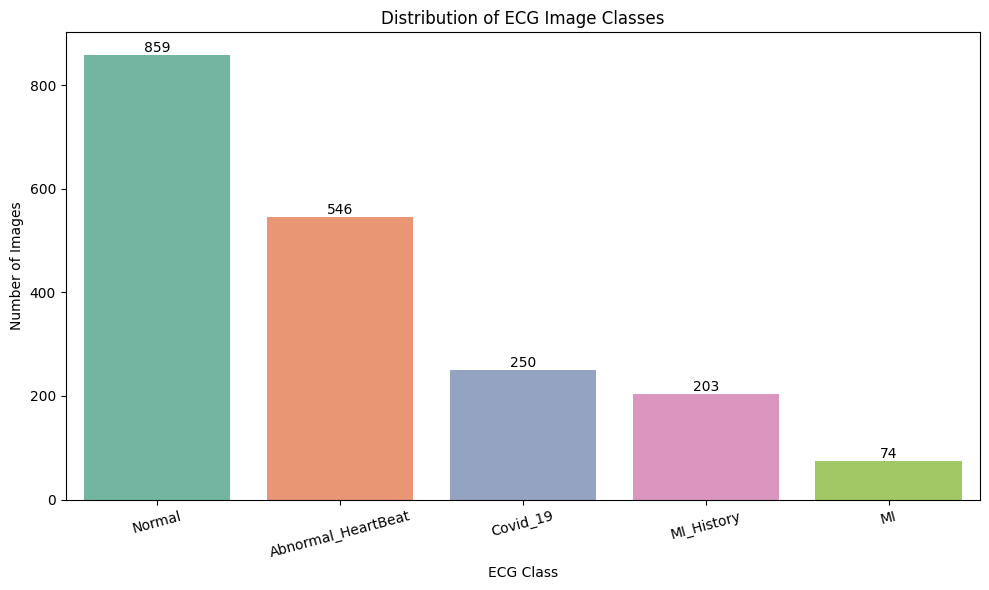

In [5]:
# @title __1.4__ Visualize Class Distribution

# Bar Plot
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Label', 'Count'])

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Label', y='Count', data=df_counts, palette='Set2')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
ax.bar_label(ax.containers[3])
ax.bar_label(ax.containers[4])
plt.title('Distribution of ECG Image Classes')
plt.ylabel('Number of Images')
plt.xlabel('ECG Class')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
# Pie Chart
fig = go.Figure(data=[go.Pie(labels=list(image_counts.keys()), values=list(image_counts.values()))])
fig.update_layout(title='Class Proportions in ECG Dataset')
fig.show()

In [ ]:
# @title __1.5__ Display Sample Images Per Class

# Function to Display Sample Images From a Folder
def display_sample_images(folder_path, title):
    files = os.listdir(folder_path)[:9]
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    axes = axes.ravel()

    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

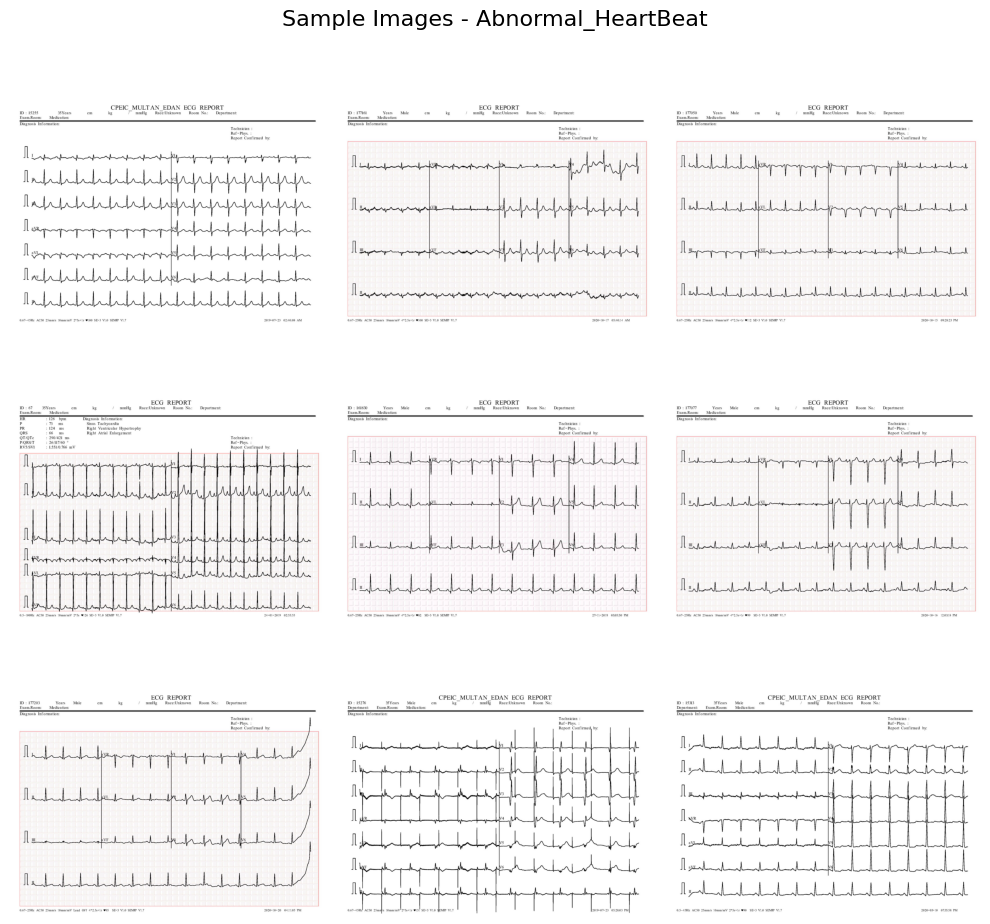

In [ ]:
# Display sample images of Abnormal HeartBeat ECG Readings
label = 'Abnormal_HeartBeat'
folder = class_folders[label]
display_sample_images(os.path.join(base_path, folder), f"Sample Images - {label}")

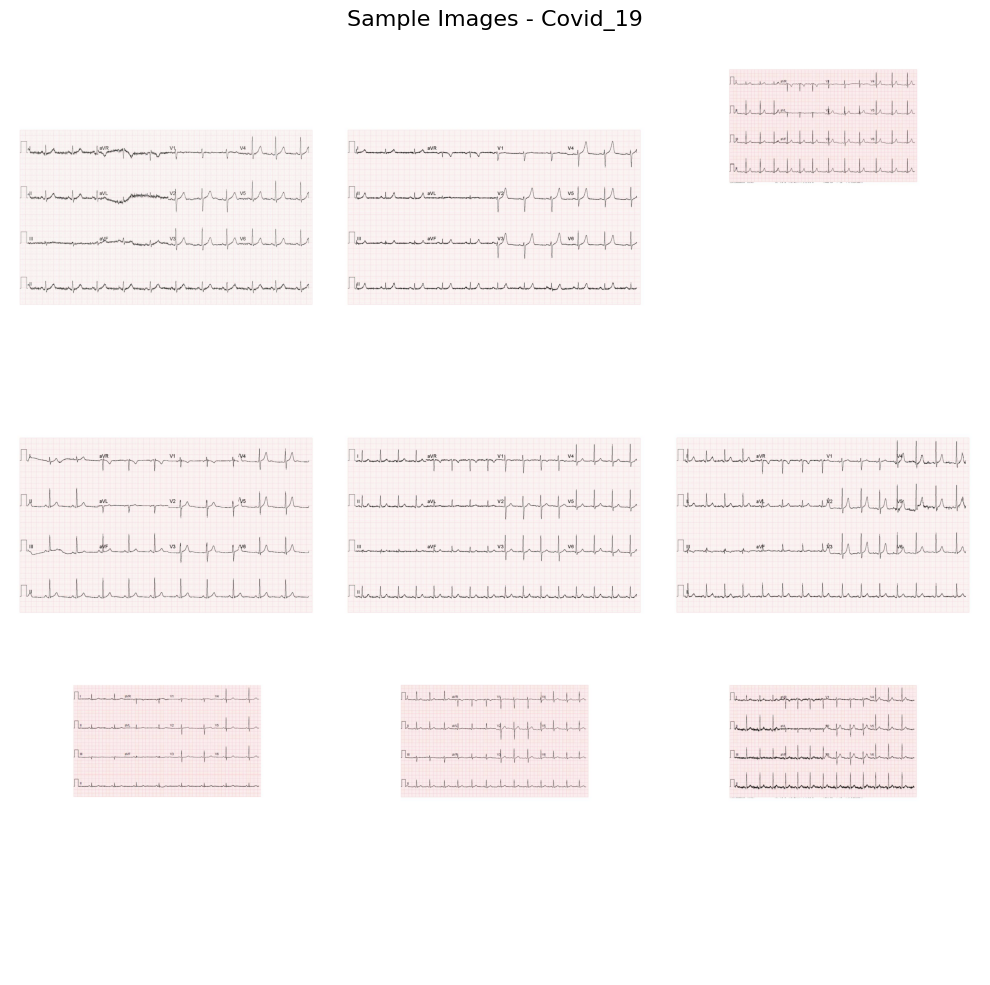

In [ ]:
# Display sample images of Covid-19 ECG Readings
label = 'Covid_19'
folder = class_folders[label]
display_sample_images(os.path.join(base_path, folder), f"Sample Images - {label}")

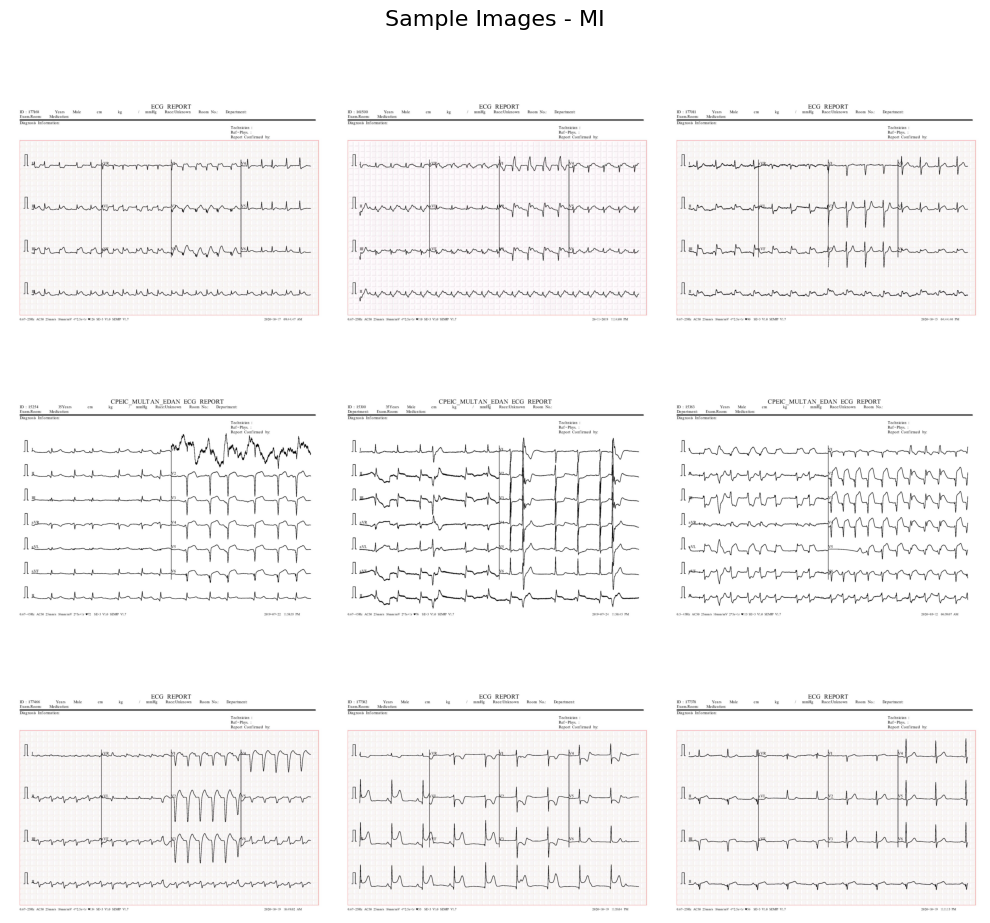

In [ ]:
# Display sample images of Myocardial Infarction (MI) ECG Readings
label = 'MI'
folder = class_folders[label]
display_sample_images(os.path.join(base_path, folder), f"Sample Images - {label}")

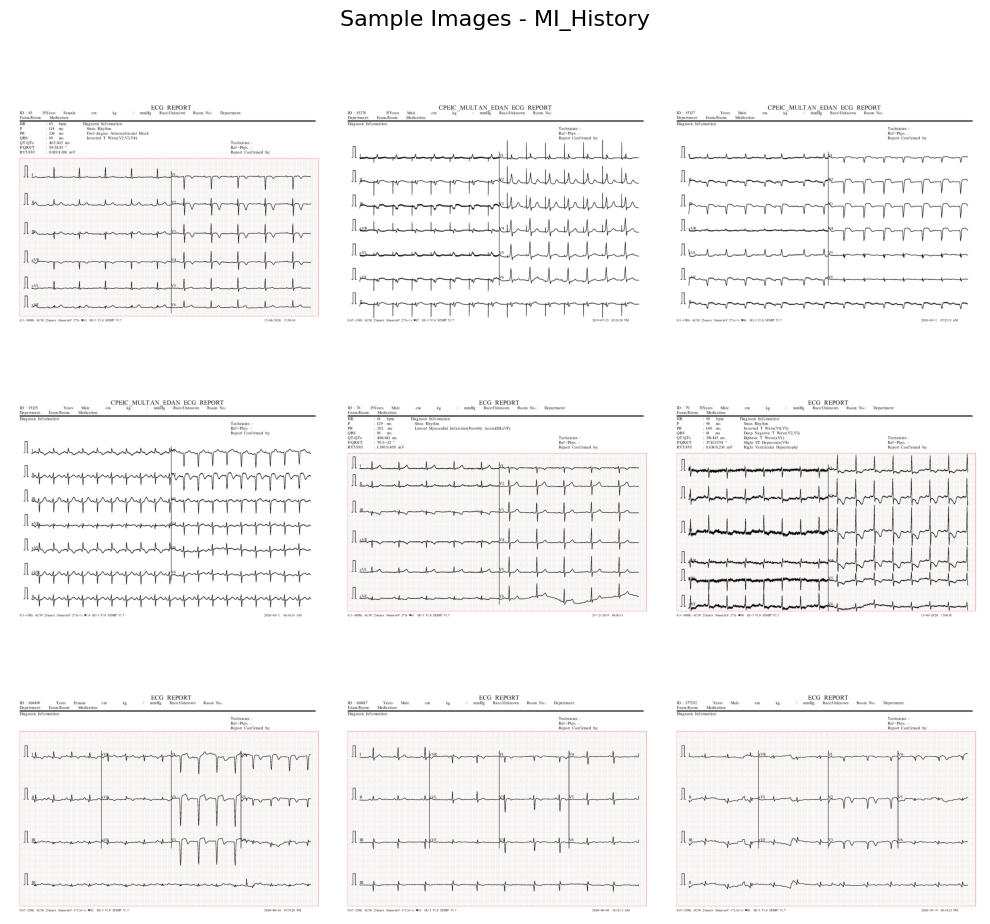

In [ ]:
# Display sample images of History of MI ECG Readings
label = 'MI_History'
folder = class_folders[label]
display_sample_images(os.path.join(base_path, folder), f"Sample Images - {label}")

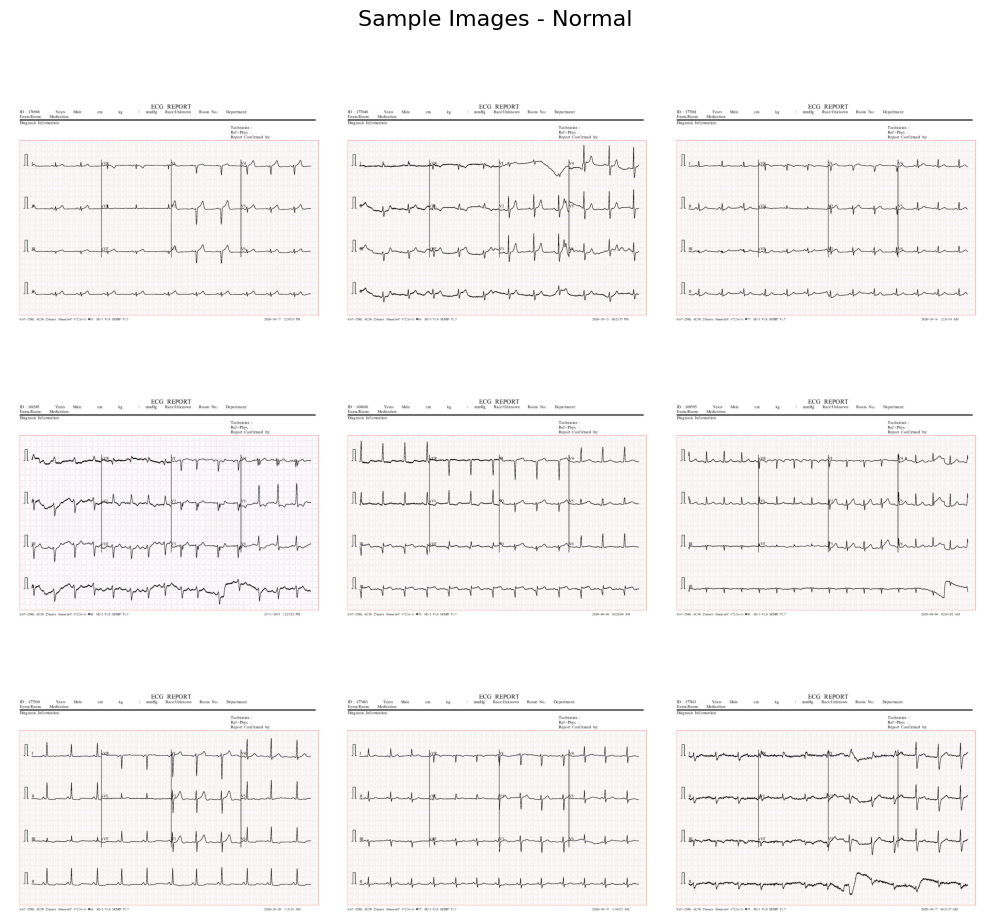

In [ ]:
# Display sample images of Normal ECG Readings
label = 'Normal'
folder = class_folders[label]
display_sample_images(os.path.join(base_path, folder), f"Sample Images - {label}")

## **Step-2:** Preprocessing, Balancing, and Splitting

In [ ]:
# @title __2.1__ Preprocess ECG Images

# Resize and Load Images From Each Class
def preprocess_images(image_folder):
    images = []
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (224, 224))
            images.append(image)
    return np.array(images)

In [ ]:
# @title __2.2__ Apply Preprocessing to All Classes

all_images = []
all_labels = []

label_map = {'Abnormal_HeartBeat': 0, 'Covid_19': 1, 'MI': 2, 'MI_History': 3, 'Normal': 4}

for label_name, folder in class_folders.items():
    folder_path = os.path.join(base_path, folder)
    processed_imgs = preprocess_images(folder_path)
    all_images.append(processed_imgs)
    all_labels += [label_map[label_name]] * len(processed_imgs)

# Combine All Classes
X = np.concatenate(all_images, axis=0)
y = np.array(all_labels)

print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Dataset shape: (1932, 224, 224, 3), Labels shape: (1932,)


In [ ]:
# @title __2.3__ Handle Class Imbalance Using SMOTE

# Flatten Images for SMOTE
X_flat = X.reshape(X.shape[0], -1)

# Apply SMOTE to Balance the Dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flat, y)

# Check New Distribution
unique, counts = np.unique(y_resampled, return_counts=True)
print("Balanced class distribution after SMOTE:")
for label, count in zip(unique, counts):
    print(f"{label}: {count} samples")

# Reshape Back to Image Format
X_resampled = X_resampled.reshape(-1, 224, 224, 3)

Balanced class distribution after SMOTE:
0: 859 samples
1: 859 samples
2: 859 samples
3: 859 samples
4: 859 samples


In [ ]:
# @title __2.4__ Split & Scale the Data

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (3436, 224, 224, 3), Test shape: (859, 224, 224, 3)


In [ ]:
# Min-Max Scaling
scaler = MinMaxScaler()

# Flatten for Scaling
X_train_flat = X_train.reshape(-1, 224 * 224 * 3)
X_test_flat = X_test.reshape(-1, 224 * 224 * 3)

# Scale Data
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshape Back to Image Format
X_train_scaled = X_train_scaled.reshape(-1, 224, 224, 3)
X_test_scaled = X_test_scaled.reshape(-1, 224, 224, 3)

# Display X_train_scaled
X_train_scaled

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

## **Step-3:** Model Training & Evaluation (ANN, CNN, VGG-19)

### __3.1__ Multi-Layer Perceptron _(ANN)_

In [6]:
# Define ANN Model
ann_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')])

# Compile the Model
ann_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,276,293 (73.53 MB)

 Trainable params: 19,276,293 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
history_ann = ann_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=25, batch_size=32)

Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.1989 - loss: 30.3964 - val_accuracy: 0.1788 - val_loss: 1.6101
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2033 - loss: 1.6097 - val_accuracy: 0.1788 - val_loss: 1.6100
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2079 - loss: 1.6095 - val_accuracy: 0.1788 - val_loss: 1.6101
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2074 - loss: 1.6094 - val_accuracy: 0.1788 - val_loss: 1.6102
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2235 - loss: 1.6088 - val_accuracy: 0.1788 - val_loss: 1.6103
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2007 - loss: 1.6095 - val_accuracy: 0.1788 - val_loss: 1.6104
Epoch 7/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2052 - loss: 1.6097 - val_accuracy: 0.1788 - val_loss: 1.6104
Epoch 8/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2032 - loss: 1.6096 - val_accuracy: 0.1788 - 

#### Evaluate ANN Model

In [ ]:
class_names = ['Abnormal_HeartBeat', 'Covid_19', 'MI', 'MI_History', 'Normal']

# Evaluate ANN
y_pred_ann = ann_model.predict(X_test_scaled).argmax(axis=1)

# Metrics
print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann))

report = classification_report(y_test, y_pred_ann, target_names = class_names)
print("\nClassification Report:\n", report)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
ANN Accuracy: 0.20139697322467986

Classification Report:
                     precision    recall  f1-score   support

Abnormal_HeartBeat       0.50      0.01      0.01       172
          Covid_19       0.00      0.00      0.00       171
                MI       0.20      1.00      0.34       172
        MI_History       0.00      0.00      0.00       172
            Normal       0.00      0.00      0.00       172

          accuracy                           0.20       859
         macro avg       0.14      0.20      0.07       859
      weighted avg       0.14      0.20      0.07       859



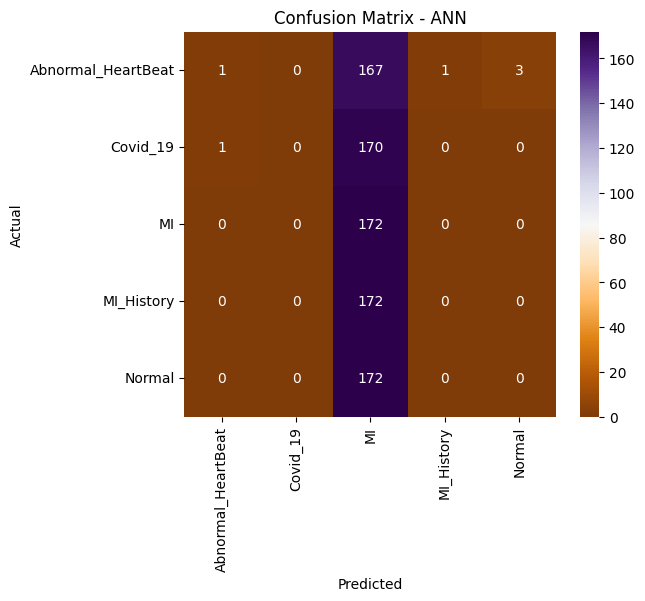

In [ ]:
# Confusion Matrix
cm_ann = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="PuOr", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

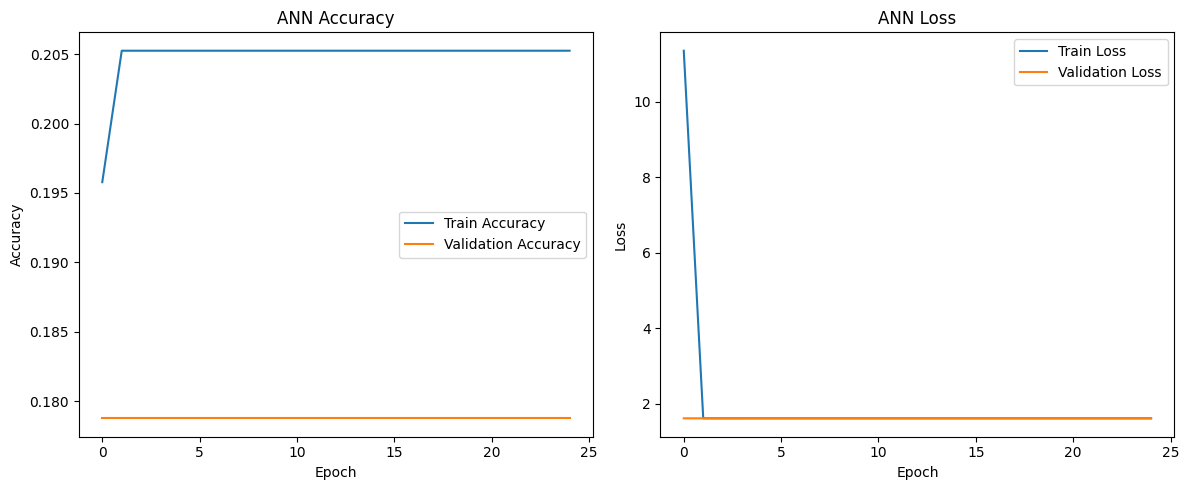

In [ ]:
# ANN Training Curves
plt.figure(figsize=(12, 5))

# Plot Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title("ANN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title("ANN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

__Observations on Model Performance:__

The results obtained from the ANN model for this image dataset are highly unsatisfactory. ANN is not suitable for handling image data effectively.
Therefore, we are using CNN for image datasets, as it is specifically designed to process such data efficiently.

### __3.2__ Convolutional Neural Network _(CNN)_

In [ ]:
# Define CNN Model
cnn_model = Sequential()

# Convolutional Layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(5, activation='softmax'))

# Compile the CNN Model
cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,213 (84.98 MB)

 Trainable params: 22,278,213 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN Model
history_cnn = cnn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.2692 - loss: 1.9984 - val_accuracy: 0.4578 - val_loss: 1.0965
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.4717 - loss: 1.1359 - val_accuracy: 0.5349 - val_loss: 0.9621
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5791 - loss: 0.9923 - val_accuracy: 0.6555 - val_loss: 0.8189
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6395 - loss: 0.8468 - val_accuracy: 0.7384 - val_loss: 0.6602
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7128 - loss: 0.7058 - val_accuracy: 0.7674 - val_loss: 0.5629
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.7845 - loss: 0.5761 - val_accuracy: 0.8154 - val_loss: 0.4851
Epoch 7/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8332 - loss: 0.4496 - val_accuracy: 0.8547 - val_loss: 0.3728
Epoch 8/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8782 - loss: 0.3343 - val_accuracy: 0.8866 -

#### Evaluate CNN Model

In [ ]:
class_names = ['Abnormal_HeartBeat', 'Covid_19', 'MI', 'MI_History', 'Normal']

# Predict
y_pred_cnn = cnn_model.predict(X_test_scaled).argmax(axis=1)

# Evaluation
print("CNN Accuracy:", accuracy_score(y_test, y_pred_cnn))

report = classification_report(y_test, y_pred_cnn, target_names = class_names)
print("\nClassification Report:\n", report)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
CNN Accuracy: 0.9045401629802096

Classification Report:
                     precision    recall  f1-score   support

Abnormal_HeartBeat       0.82      0.80      0.81       172
          Covid_19       0.97      0.99      0.98       171
                MI       0.99      0.97      0.98       172
        MI_History       0.93      0.91      0.92       172
            Normal       0.81      0.85      0.83       172

          accuracy                           0.90       859
         macro avg       0.91      0.90      0.90       859
      weighted avg       0.91      0.90      0.90       859



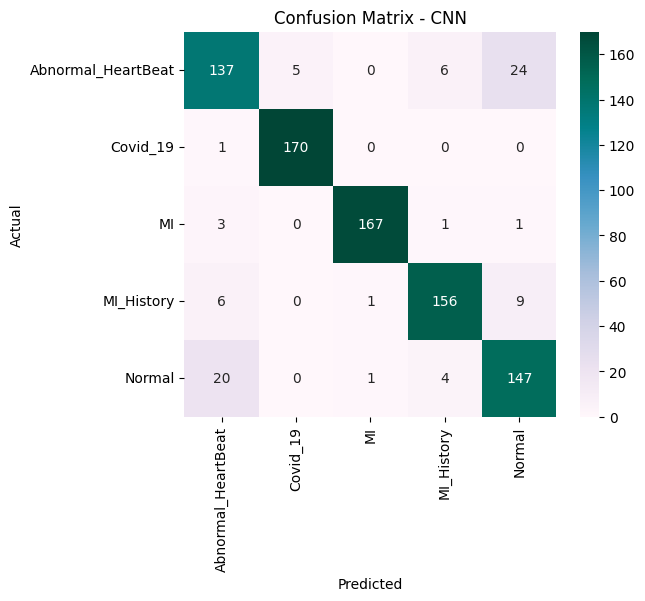

In [ ]:
# Confusion Matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="PuBuGn", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

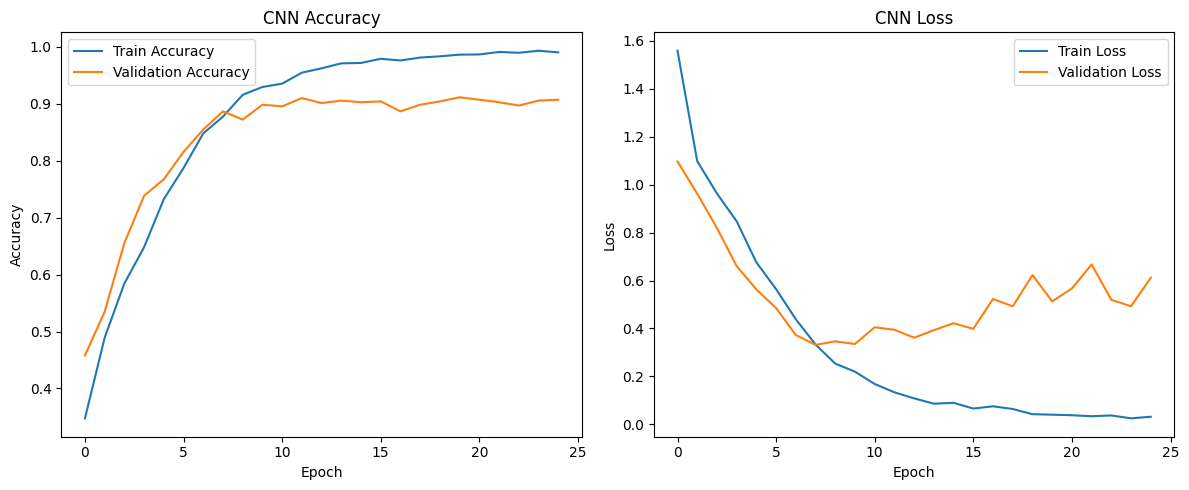

In [ ]:
# CNN Training Curves
plt.figure(figsize=(12, 5))

# Plot Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### __3.3__ Visual Geometry Group _(VGG-19)_

In [10]:
# Load the VGG19 Base Model Without the Top Classification Layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the Base Layers to Retain Learned Features
base_model.trainable = False

# Build the Full VGG19 Model
vgg_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the VGG19 Model
vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,002,565 (125.89 MB)

 Trainable params: 12,978,181 (49.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Train the VGG19 Model
history_vgg = vgg_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 32s 371ms/step - accuracy: 0.5510 - loss: 1.0836 - val_accuracy: 0.6512 - val_loss: 0.8650
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.6082 - loss: 0.9526 - val_accuracy: 0.7151 - val_loss: 0.7625
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.6572 - loss: 0.8733 - val_accuracy: 0.7209 - val_loss: 0.7201
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 273ms/step - accuracy: 0.6615 - loss: 0.8279 - val_accuracy: 0.7398 - val_loss: 0.6761
Epoch 5/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.7026 - loss: 0.7739 - val_accuracy: 0.7703 - val_loss: 0.6433
Epoch 6/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 0.7221 - loss: 0.7154 - val_accuracy: 0.7936 - val_loss: 0.5981
Epoch 7/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 279ms/step - accuracy: 0.7219 - loss: 0.7086 - val_accuracy: 0.7980 - val_loss: 0.5732
Epoch 8/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.7540 - loss: 0.6835 - val_accu

#### Evaluate VGG19 Model

In [ ]:
# Predict
y_pred_vgg = vgg_model.predict(X_test_scaled).argmax(axis=1)

# Evaluation
print("VGG-19 Accuracy:", accuracy_score(y_test, y_pred_vgg))

report = classification_report(y_test, y_pred_vgg, target_names = class_names)
print("\nClassification Report:\n", report)

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 626ms/step
VGG-19 Accuracy: 0.8637951105937136

Classification Report:
                     precision    recall  f1-score   support

Abnormal_HeartBeat       0.75      0.74      0.74       172
          Covid_19       0.96      0.94      0.95       171
                MI       0.93      0.90      0.92       172
        MI_History       0.89      0.82      0.85       172
            Normal       0.80      0.92      0.85       172

          accuracy                           0.86       859
         macro avg       0.87      0.86      0.86       859
      weighted avg       0.87      0.86      0.86       859



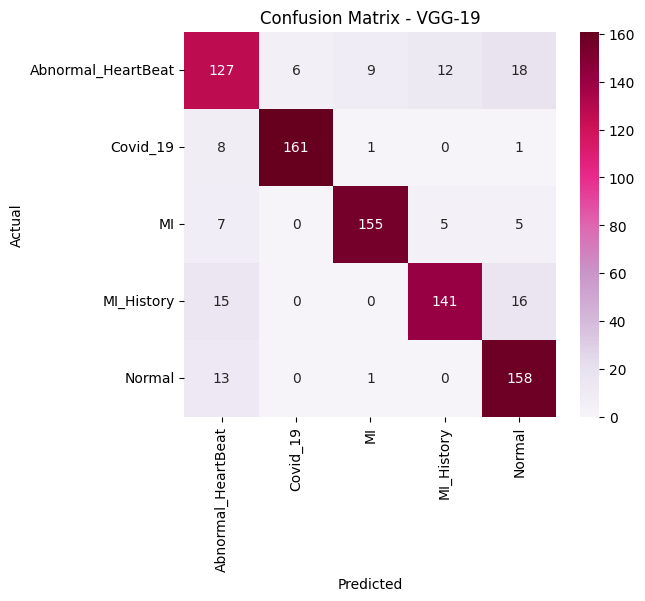

In [ ]:
# Confusion Matrix
cm_vgg = confusion_matrix(y_test, y_pred_vgg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_vgg, annot=True, fmt="d", cmap="PuRd", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - VGG-19")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

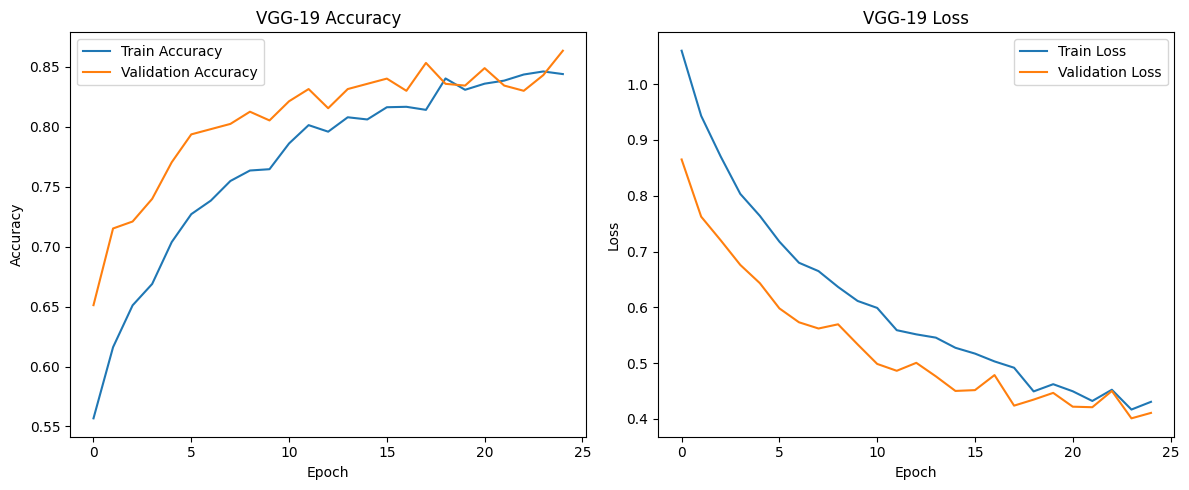

In [ ]:
# VGG19 Training Curves
plt.figure(figsize=(12, 5))

# Plot Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title("VGG-19 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title("VGG-19 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## **Step-4:** Saving Trained Models for Deployment

In [7]:
# Save MinMaxScaler Used in Preprocessing
import pickle

with open("minmax_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Scaler Saved as minmax_scaler.pkl")

Scaler Saved as minmax_scaler.pkl


In [8]:
# Save CNN Model in .h5 Format
cnn_model.save("cnn_ecg_model.h5")
print("CNN Model Saved as cnn_ecg_model.h5")

CNN Model Saved as cnn_ecg_model.h5


In [9]:
# Save VGG19 Model in .h5 Format
vgg_model.save("vgg19_ecg_model.h5")
print("VGG-19 Model Saved as vgg19_ecg_model.h5")

VGG-19 Model Saved as vgg19_ecg_model.h5


## ✅ __Conclusion__

This project successfully demonstrates the application of deep learning techniques for classifying ECG images into five medical conditions: Abnormal Heartbeat, COVID-19, Myocardial Infarction (MI), MI History, and Normal.

To better understand model suitability, we experimented with three architectures: **ANN, CNN, and VGG-19**.
___
### 🔍 __Key Observations:__

- **ANN (Multi-Layer Perceptron)** performed very poorly with an overall accuracy of **20.13%**. Most classes were misclassified except MI, which dominated due to its over-representation in feature patterns. This supports the theoretical understanding that ANN is not suitable for raw image data, and we included it to validate this practically.
  
- **CNN** achieved the highest accuracy of **90.45%**. It captured spatial features effectively and showed strong precision and recall across all classes. However, the final training accuracy was **98.85%**, indicating possible **overfitting**, which could be further addressed with data augmentation, dropout tuning, or early stopping.
  
- **VGG-19 (Transfer Learning)** provided a balanced performance with **86.38% accuracy**. While slightly lower than CNN, it generalized better (training accuracy: 84.27%) and performed more consistently across all classes. This model can be a safer choice when deploying in real-world scenarios to avoid overfitting.
___
### 📌 __Final Thoughts:__

 - **Image size 224×224** was used throughout to align with deep learning best practices and pretrained model input requirements.
 - SMOTE oversampling effectively handled class imbalance.
 - The CNN and VGG-19 models are both saved in `.h5` and `.pkl` formats for flexibility in deployment.

This project demonstrates a full machine learning pipeline — from preprocessing and visualization to model training, evaluation, and saving — tailored specifically to healthcare image data using ECG scans.
